# Predicting Tumor Width Using Metabolites

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 04APR2021

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goal**: To explore all the RCC Metadata with respects to metabolites. <br>
**Update**: Included voting regressor.

### Notebook Outline

1. [Load Data](#1)
2. [Tumor Width](#2)
3. [Plotting Correlation Graphs](#3)
4. [Cohort Characteristics](#4)
4. [Predicting Tumor Width](#5)

## Import Libraries

In [23]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels as sms
from statsmodels.stats import multitest
from scipy.stats import shapiro
from decimal import Decimal
from statistics import mean
#For Seaborn plots
import seaborn as sns; sns.set(style='white')

#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk')

In [24]:
import dill
filepath = 'tumor_size_prediction_model.pkl'
dill.load_session('workspace/tumor_size_prediction_model.pkl') # Load the session

## 1. Load Data

In [25]:
import pandas as pd
RCCdataframe = pd.read_excel('data/RCCdataframe.xlsx')

Define features for RCC, numerical. 

In [26]:
df_features = RCCdataframe.drop(
    ['Patient ID', 'Collection', 'Gender', 'Race', 'BMI', 
     'Smoker', 'Age', 'Groups', 'Metastatic', 'SubTypes', 
     'Nuclear Grade','Groups', 'Metastatic', 'Sample ID',
     'SubTypes','Nuclear Grade', 'Grade', 'Tstage', 
     'Tstage Group', 'Nstage', 'Mstage', 
     'Stage', 'Grouped Stage','Tumor Width'], axis=1)

## 2. Tumor Width and Metabolites Correlation
<a id="2"></a>

In [27]:
missing = RCCdataframe['Tumor Width'].isnull().sum()
print ('Number of missing tumor width data is:', missing)

Number of missing tumor width data is: 2


_Fill in missing values_

In [28]:
# fill with mean
mean = RCCdataframe['Tumor Width'].mean()
RCCdataframe['Tumor Width'].fillna(mean, inplace=True)
print ('Total number of samples with tumor width: ', RCCdataframe.shape[0])

Total number of samples with tumor width:  82


_Calculate Correlations_

In [29]:
corr_tumor = []
for column in df_features.columns:
    col_corr = pd.DataFrame(np.corrcoef(df_features[column].astype(float), 
                                        RCCdataframe['Tumor Width'])).abs()
    if col_corr[1][0] > abs(0.55):
        corr_tumor.append(column)
print (corr_tumor)
print (len(corr_tumor))

[648, 1695, 1804, 2180, 2567, 2745, 3163, 5362, 5408, 6681]
10


In [30]:
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [31]:
MS_labels[MS_labels.ID.isin(corr_tumor)]

,Unnamed: 0,ID,Mode,RT [min],Name,Formula
647,647,648,positive,2.901,648,C29 H64 N9 O4 P3
1694,1694,1695,positive,2.900,1695,NaN
1803,1803,1804,positive,3.654,1804,C25 H60 N9 O12 P
2179,2179,2180,positive,3.653,2180,NaN
2566,2566,2567,positive,3.668,2567,C28 H70 N9 O6 P3 S
2744,2744,2745,positive,1.873,2745,C8 H10 N6 O2
3162,3162,3163,positive,3.530,3163,C5 H15 N10 O2 P
5361,5361,5362,negative,3.467,5362,C11 H19 O2 P S
5407,5407,5408,negative,3.076,"1-(beta-D-Ribofuranosyl)-1,2-dihydropyrimidine",C9 H14 N2 O4
6680,6680,6681,negative,2.801,Asparaginyl-4-hydroxyproline,C9 H15 N3 O5


**5 features on the `corr_tumor` are identified as PEG are probably contaminant from sample collection protocols. This features were removed**

In [32]:
corr_tumor = [2745, 3163, 5362, 6681]
MS_labels[MS_labels.ID.isin(corr_tumor)]

,Unnamed: 0,ID,Mode,RT [min],Name,Formula
2744,2744,2745,positive,1.873,2745,C8 H10 N6 O2
3162,3162,3163,positive,3.530,3163,C5 H15 N10 O2 P
5361,5361,5362,negative,3.467,5362,C11 H19 O2 P S
6680,6680,6681,negative,2.801,Asparaginyl-4-hydroxyproline,C9 H15 N3 O5


_Create a Dataframe for Correlated metabolites and Tumor Width_

In [33]:
#TWfeatures is the dataframe for highly correlated metabolites
TWfeatures = RCCdataframe[corr_tumor]
TWfeatures_scaled =(TWfeatures - TWfeatures.mean(axis=0))/TWfeatures.std(axis=0) #autoscaling

In [34]:
# index of tumor width in RCCdataframe
tw_loc = RCCdataframe.columns.get_loc("Tumor Width") 


marker_unscaled = RCCdataframe.iloc[:, tw_loc].to_frame().join(TWfeatures)
marker = RCCdataframe.iloc[:, tw_loc].to_frame().join(TWfeatures_scaled)
marker.columns

Index(['Tumor Width', 2745, 3163, 5362, 6681], dtype='object')

In [35]:
correlation, pvalue = [], []
for metabolite in marker.columns[1:]:
    r, pval = scipy.stats.pearsonr(RCCdataframe[metabolite], RCCdataframe['Tumor Width'])
    correlation.append(r)
    pvalue.append(pval)
# intialise data of lists. 
data = {'Features': marker.columns[1:], 'r':correlation, 'p-value':pvalue} 
  
# Create DataFrame 
corr_sig = pd.DataFrame(data) 
corr_sig.head()

,Features,r,p-value
0,2745,0.573198,1.823436e-08
1,3163,0.584958,7.882361e-09
2,5362,0.564808,3.252094e-08
3,6681,0.575470,1.554695e-08


## 3. Plotting Correlation Graphs

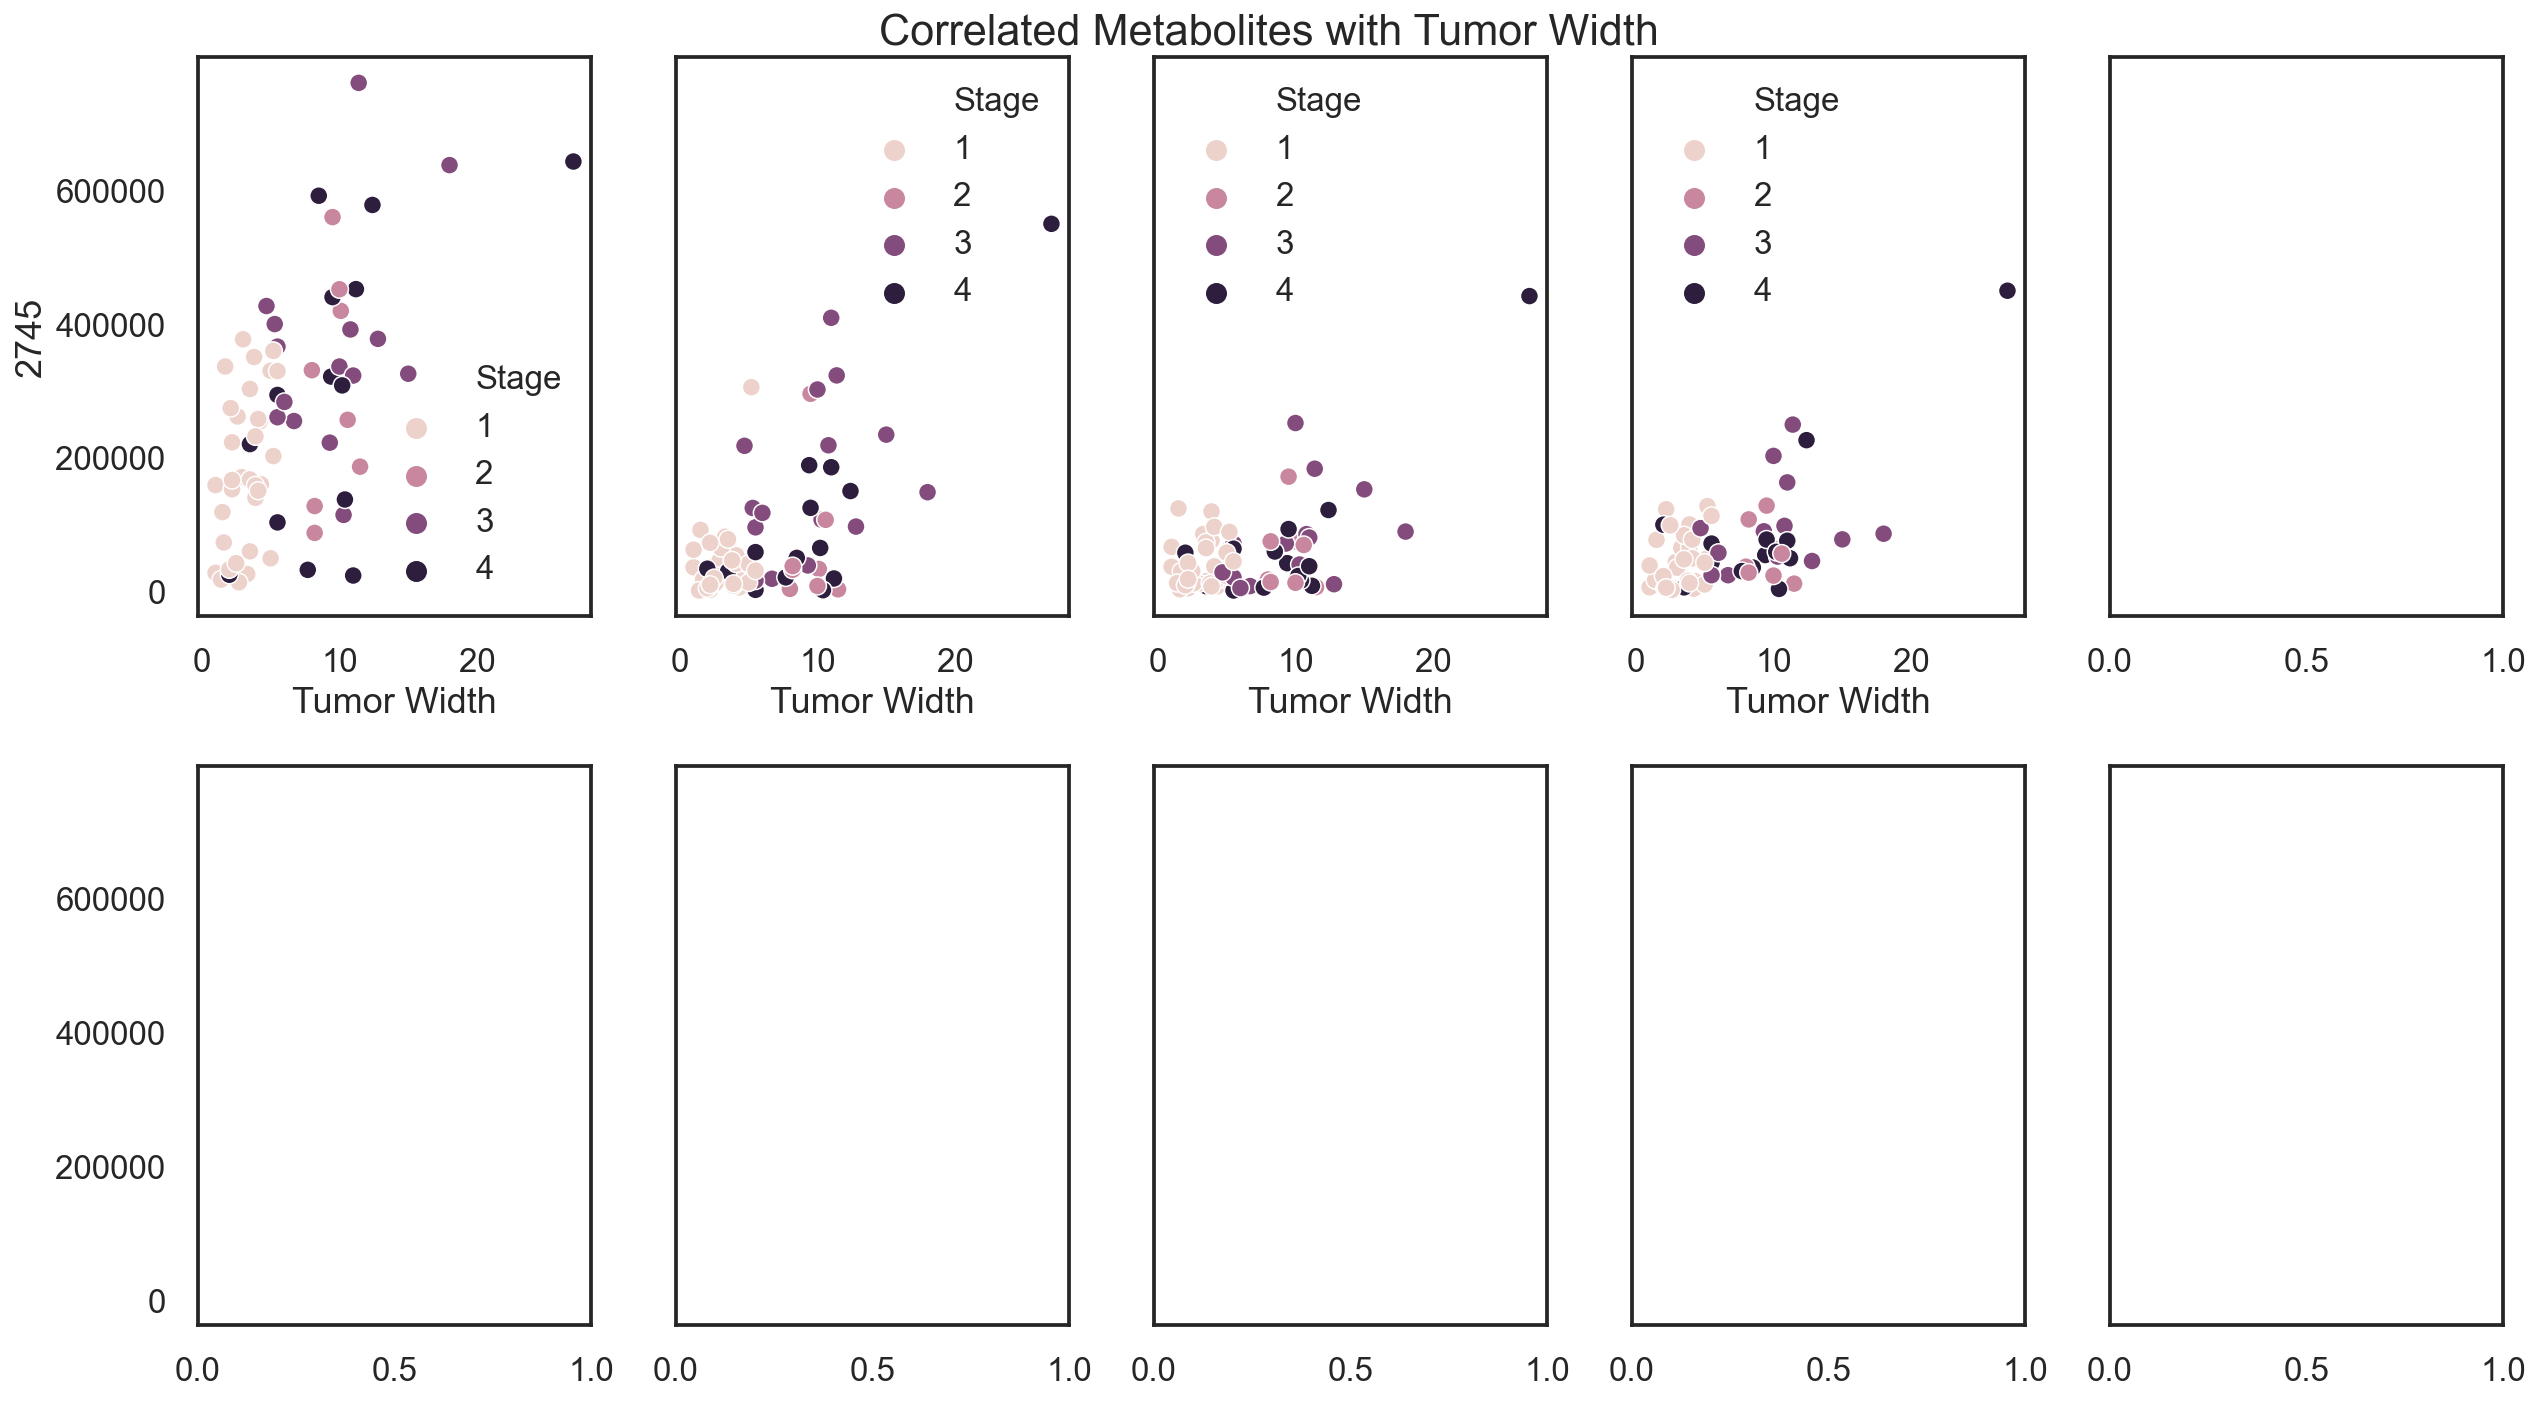

In [36]:
fig, ax = plt.subplots(2, 5, sharey=True, figsize=(18, 10))

for idx, feat in enumerate(marker_unscaled.columns[1:]):
    if idx <=5:
        sns.scatterplot(x='Tumor Width', y=feat, data=RCCdataframe, hue='Stage', ax=ax[0,idx])
    else: 
        sns.scatterplot(x='Tumor Width', y=feat, data=RCCdataframe, hue='Stage',ax=ax[1,idx-5])
        
fig.suptitle('Correlated Metabolites with Tumor Width')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

#plt.savefig('demo1.svg')
plt.show()
plt.clf()
plt.close()

## 4. Cohort Characteristics

### Gender

In [37]:
print(RCCdataframe['Gender'].value_counts())
print(RCCdataframe['Gender'].value_counts(normalize=True)*100)

Male      45
Female    36
Name: Gender, dtype: int64
Male      55.555556
Female    44.444444
Name: Gender, dtype: float64


### Smoker

In [38]:
print(RCCdataframe['Smoker'].value_counts())
print(RCCdataframe['Smoker'].value_counts(normalize=True)*100)

Never      51
Former     24
Current     7
Name: Smoker, dtype: int64
Never      62.195122
Former     29.268293
Current     8.536585
Name: Smoker, dtype: float64


### Race

In [39]:
print(RCCdataframe['Race'].value_counts())
print(RCCdataframe['Race'].value_counts(normalize=True)*100)

White                             56
Black/AA                          20
Unk/Missing                        2
Mixed                              1
American-Indian/Alaskan-Native     1
Asian                              1
Name: Race, dtype: int64
White                             69.135802
Black/AA                          24.691358
Unk/Missing                        2.469136
Mixed                              1.234568
American-Indian/Alaskan-Native     1.234568
Asian                              1.234568
Name: Race, dtype: float64


### RCC SubTypes

In [40]:
print(RCCdataframe['SubTypes'].value_counts())
print(RCCdataframe['SubTypes'].value_counts(normalize=True)*100)

Pure Clear Cell         57
Papillary               10
Clear Cell Papillary     6
Chromophobe              5
Unclassified             4
Name: SubTypes, dtype: int64
Pure Clear Cell         69.512195
Papillary               12.195122
Clear Cell Papillary     7.317073
Chromophobe              6.097561
Unclassified             4.878049
Name: SubTypes, dtype: float64


### Nuclear Grades

In [41]:
print(RCCdataframe['Nuclear Grade'].value_counts())
print(RCCdataframe['Nuclear Grade'].value_counts(normalize=True)*100)

2.0    30
3.0    29
4.0    19
Name: Nuclear Grade, dtype: int64
2.0    38.461538
3.0    37.179487
4.0    24.358974
Name: Nuclear Grade, dtype: float64


### RCC Stages

In [42]:
print(RCCdataframe['Stage'].value_counts())
print(RCCdataframe['Stage'].value_counts(normalize=True)*100)

1.0    33
3.0    15
4.0    14
2.0     8
Name: Stage, dtype: int64
1.0    47.142857
3.0    21.428571
4.0    20.000000
2.0    11.428571
Name: Stage, dtype: float64


### Age and BMI

In [43]:
print(RCCdataframe['Age'].mean(axis=0))
print(RCCdataframe['Age'].std(axis=0))

60.902439024390254
13.077234724963517


In [44]:
print(RCCdataframe['BMI'].mean(axis=0))
print(RCCdataframe['BMI'].std(axis=0))

29.304878048780488
5.689928343384082


## 5. Predicting Tumor Width

### Import Libraries

https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

In [45]:
# Import machine learning libraries
# Test train split and K-fold validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
# MAE metrics
from sklearn.metrics import mean_absolute_error
# R2 score
from sklearn.metrics import r2_score
# Predicition plot
from yellowbrick.regressor import PredictionError
# Residual Plot
from yellowbrick.regressor import ResidualsPlot
# Preprocessing
from sklearn import preprocessing
# Scaling 
from sklearn.preprocessing import StandardScaler

### Regressors

**residual plot functions**

In [46]:
def residual_plot(features, target, regressor):
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2,
                                                    random_state=42)
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    fig = visualizer.poof()
    return fig

In [47]:
def residual_plot_save(features, target, regressor, figtitle):
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2,
                                                    random_state=42)
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    save = visualizer.show(outpath=figtitle)
    fig = visualizer.poof()
    return save, fig

**regression metrics function**

In [48]:
def regressor_metric(features, target, regressor): 
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2,
                                                    random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    R2 = r2_score(y_test, y_pred)
    metric = dict(MAE = round(MAE,2),
                  MAPE = round(MAPE,2), 
                  R2 = round(R2,2))
    return metric

**prediction error plot functions**

In [49]:
def error_plot(features, target, regressor):
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2,
                                                    random_state=42)
    visualizer = PredictionError(regressor)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    fig = visualizer.poof()
    return fig

In [50]:
def error_plot_save(features, target, regressor, figtitle):
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2,
                                                    random_state=42)
    visualizer = PredictionError(regressor)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    save = visualizer.show(outpath=figtitle)
    fig = visualizer.poof()
    return save, fig

**models**

In [51]:
# model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk')

In [52]:
gb = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(n_estimators = 10, random_state=42, n_jobs=-1)
dt = DecisionTreeRegressor(random_state=42)
knn = neighbors.KNeighborsRegressor()
ridge = linear_model.Ridge(random_state=42)
svr = SVR(kernel='rbf')
lasso = linear_model.Lasso(random_state=42)
el = linear_model.ElasticNet(random_state=42)

lin = LinearRegression()

BR = linear_model.BayesianRidge()

#voting_reg = VotingRegressor(
#    estimators=[('el', el), ('svr', svr), 
#                ('BR', BR), ('lin', lin),])

voting_reg = VotingRegressor(
    estimators=[('el', el), ('svr', svr), ('ridge', ridge)])

from sklearn.svm import LinearSVR
svm_reg_lin = LinearSVR(epsilon=2.5, 
                    random_state=42)

svm_reg_poly = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)

residual_plot(df_features[TWfeatures.columns].values,
             RCCdataframe['Tumor Width'], svm_reg_poly);

### Residual Plot

*ElasticNet Regressor*

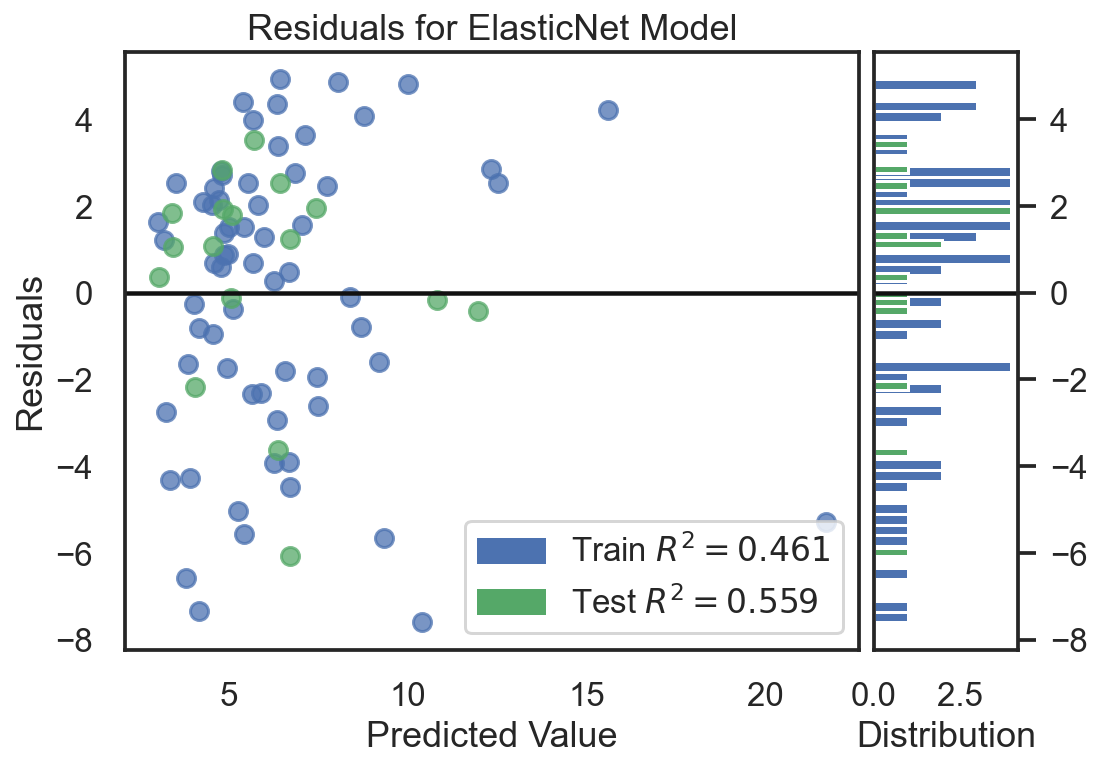

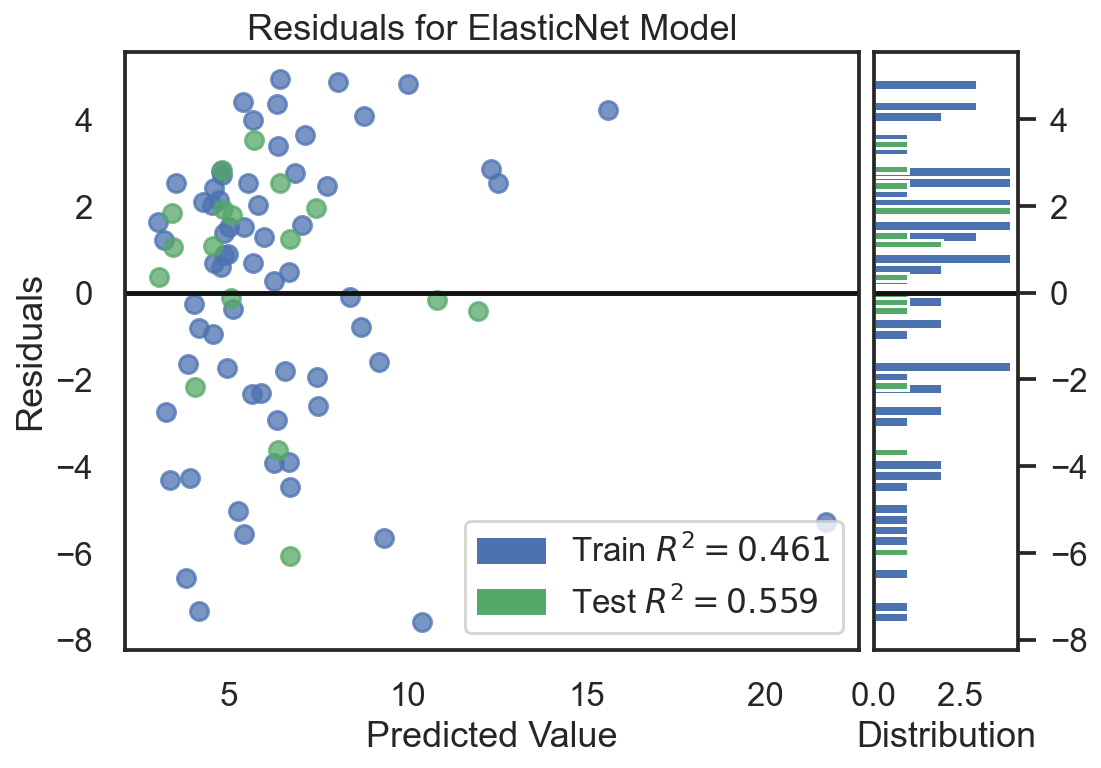

In [53]:
residual_plot(df_features[TWfeatures.columns].values,
             RCCdataframe['Tumor Width'], el);

#residual_plot_save(df_features[TWfeatures.columns].values,
#             RCCdataframe['Tumor Width'], el, 'ElasticNet_ResidualPlot.svg');

*SupportVectorRegressor*

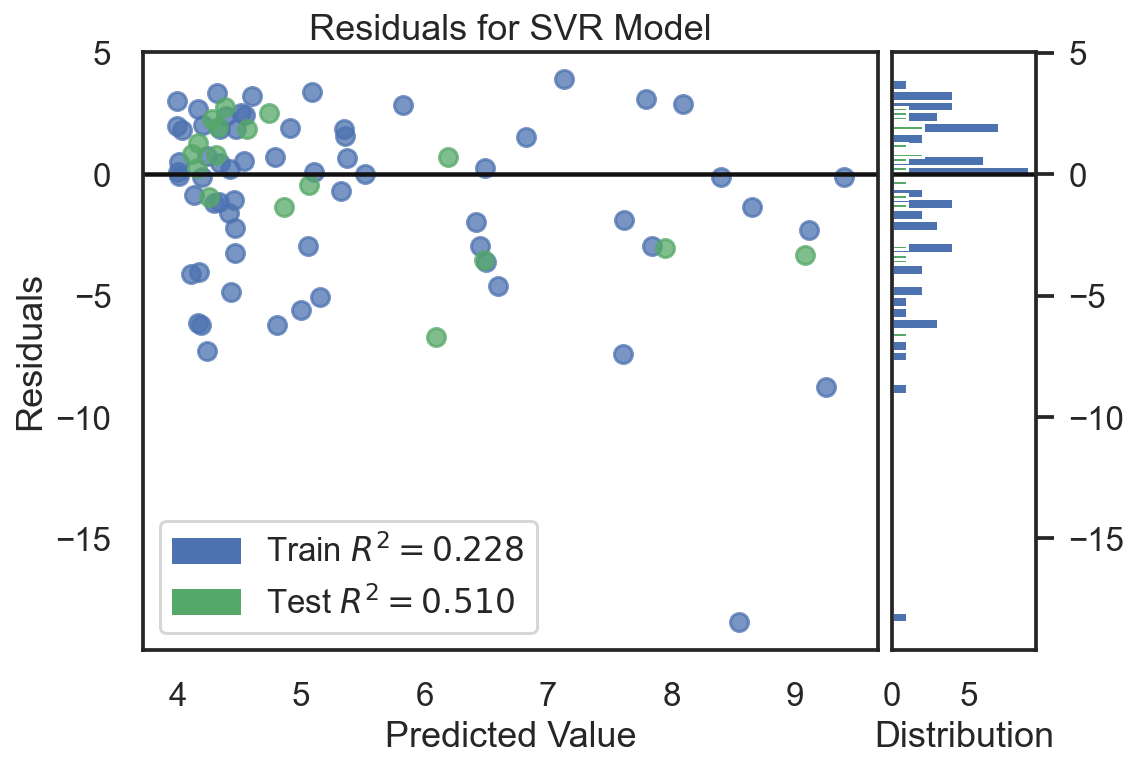

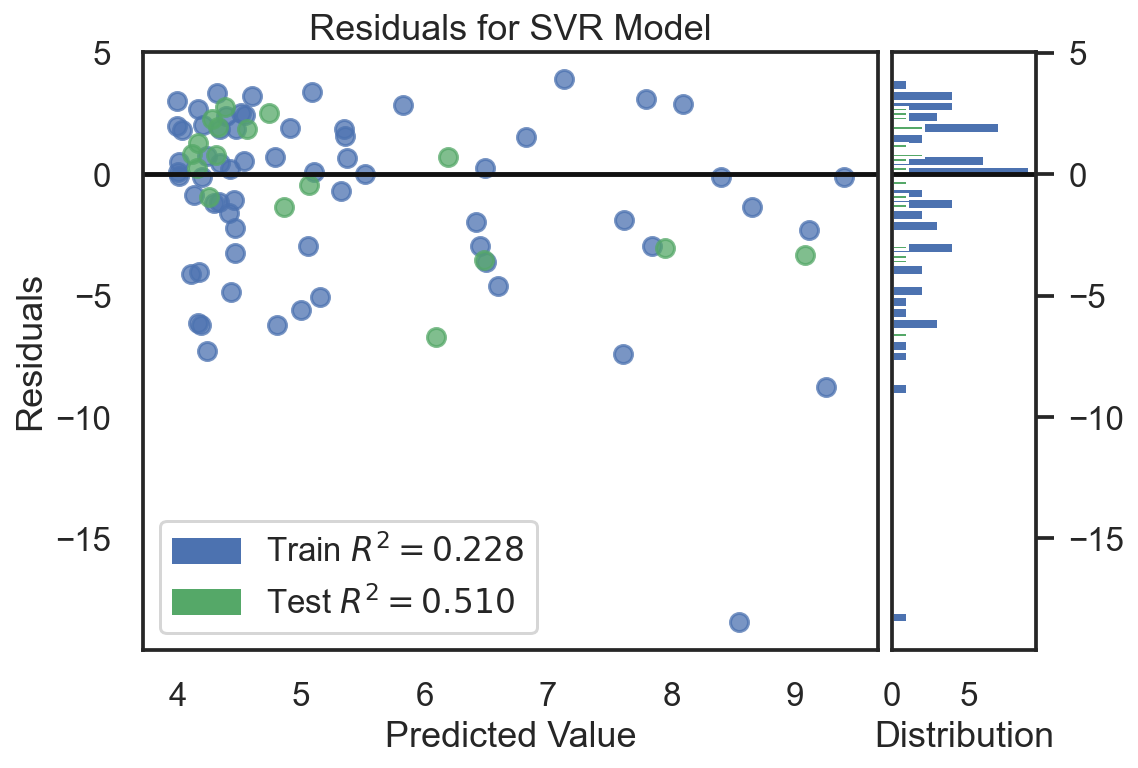

In [54]:
residual_plot(df_features[TWfeatures.columns].values,
             RCCdataframe['Tumor Width'], svr);
#residual_plot_save(df_features[TWfeatures.columns].values,
#             RCCdataframe['Tumor Width'], svr, 'SupportVector_ResidualPlot.svg');

*RidgeRegressor*

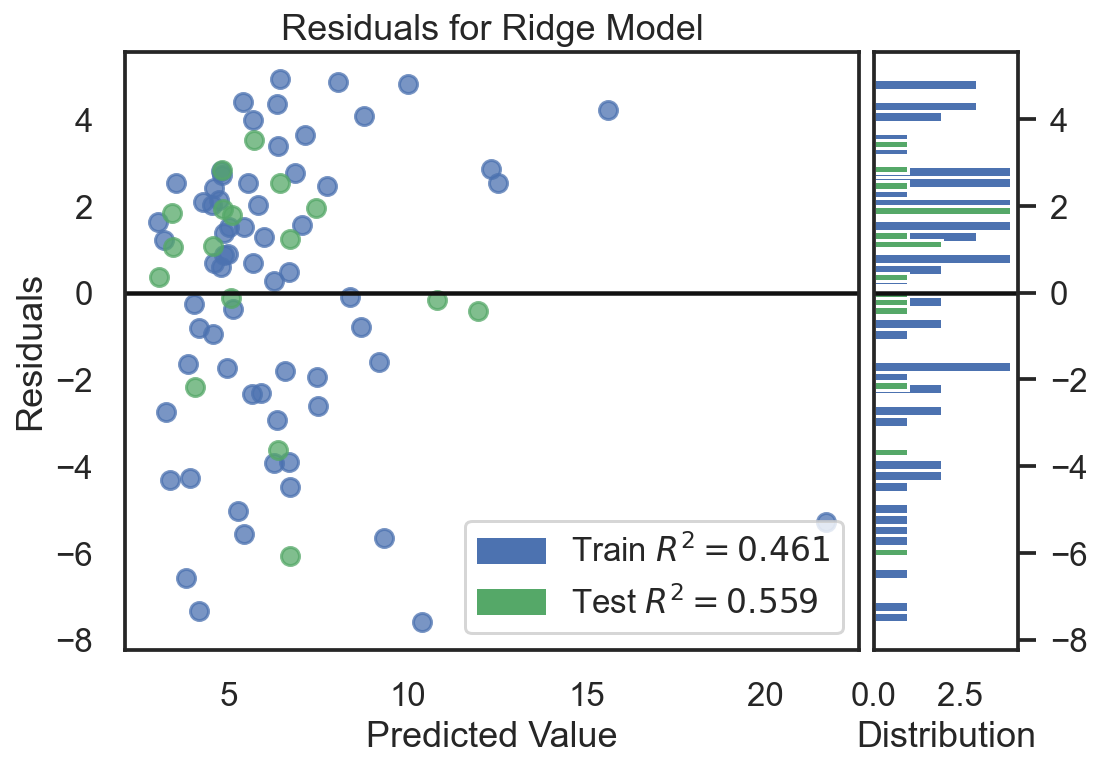

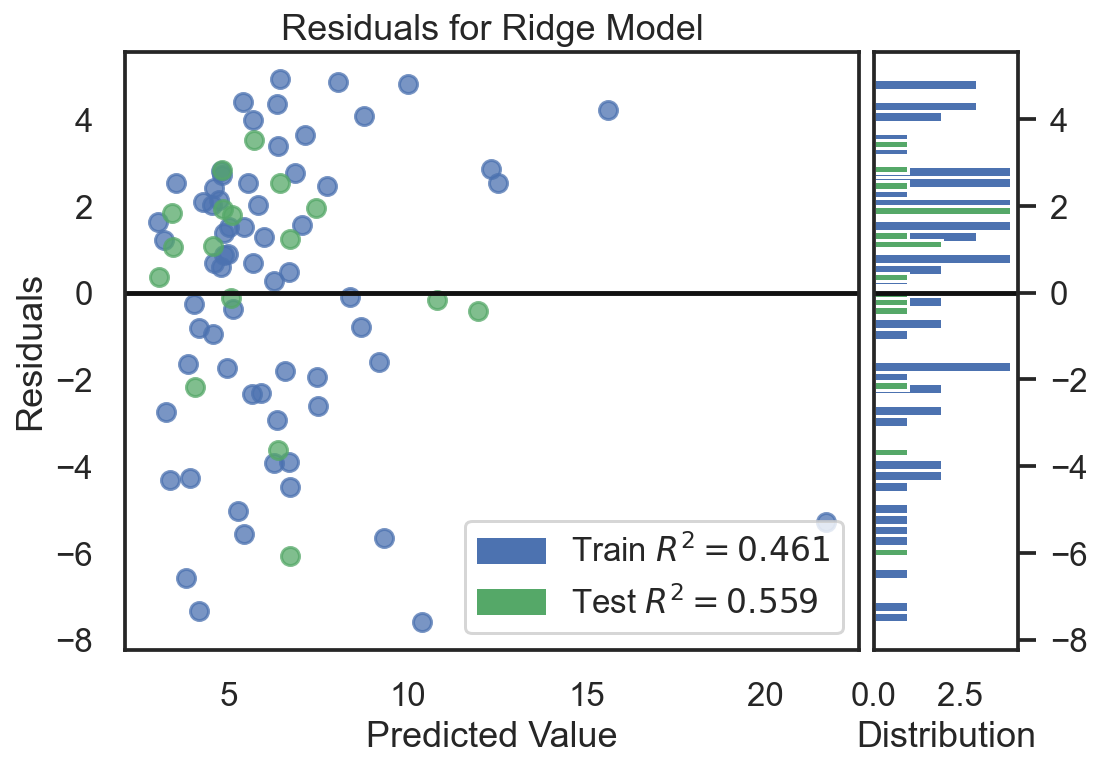

In [55]:
residual_plot(df_features[TWfeatures.columns].values,
             RCCdataframe['Tumor Width'], ridge);
#residual_plot_save(df_features[TWfeatures.columns].values,
#             RCCdataframe['Tumor Width'], ridge, 'Ridge_ResidualPlot.svg');

_Voting Regressor_

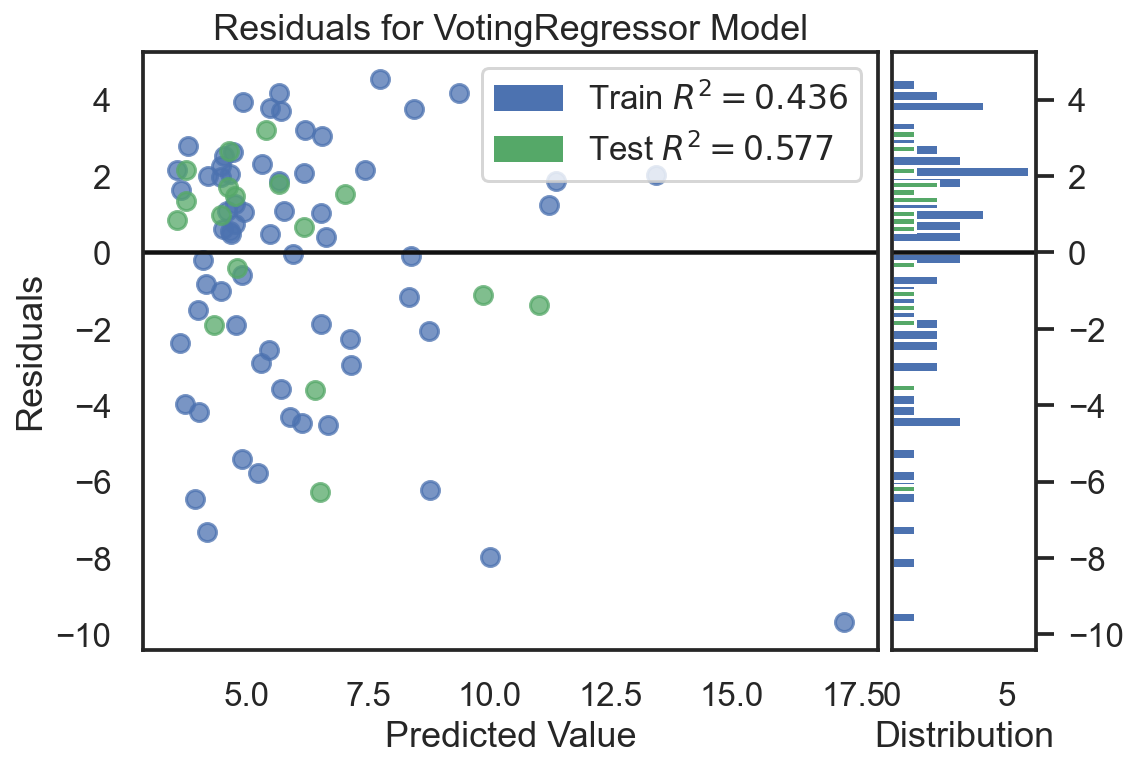

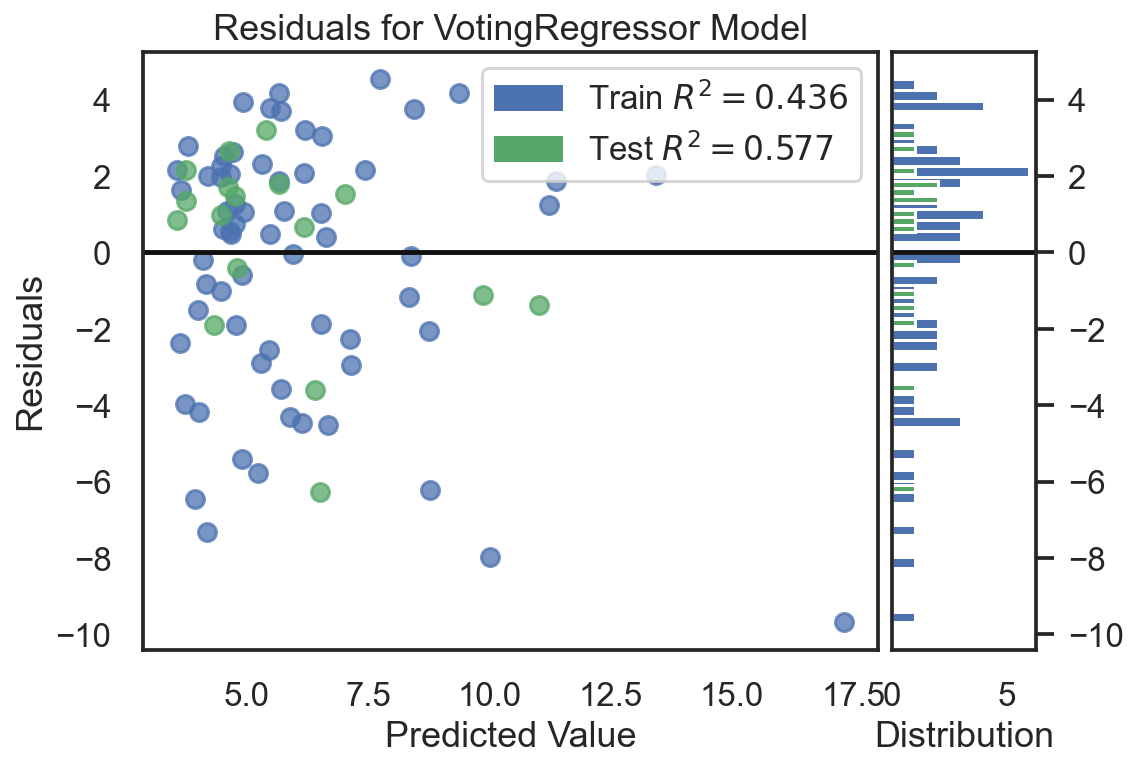

In [56]:
residual_plot(df_features[TWfeatures.columns].values,
             RCCdataframe['Tumor Width'], voting_reg);
#residual_plot_save(df_features[TWfeatures.columns].values,
#             RCCdataframe['Tumor Width'], voting_reg, 'VotingRegressor_ResidualPlot.svg');

### Regression Metrics

*ElasticNetRegressor*

In [57]:
regressor_metric(df_features[TWfeatures.columns].values, 
                 RCCdataframe['Tumor Width'], el)

{'MAE': 1.92, 'MAPE': 51.31, 'R2': 0.56}

*SupportVectorRegressor*

In [58]:
regressor_metric(df_features[TWfeatures.columns].values, 
                 RCCdataframe['Tumor Width'], svr)

{'MAE': 2.03, 'MAPE': 50.17, 'R2': 0.51}

*RidgeRegressor*

In [59]:
regressor_metric(df_features[TWfeatures.columns].values, 
                 RCCdataframe['Tumor Width'], ridge)

{'MAE': 1.92, 'MAPE': 51.31, 'R2': 0.56}

_Voting Regressor_

In [60]:
regressor_metric(df_features[TWfeatures.columns].values,
             RCCdataframe['Tumor Width'], voting_reg)

{'MAE': 1.94, 'MAPE': 50.62, 'R2': 0.58}

### Prediction Error Plot

*ElasticNetRegressor*

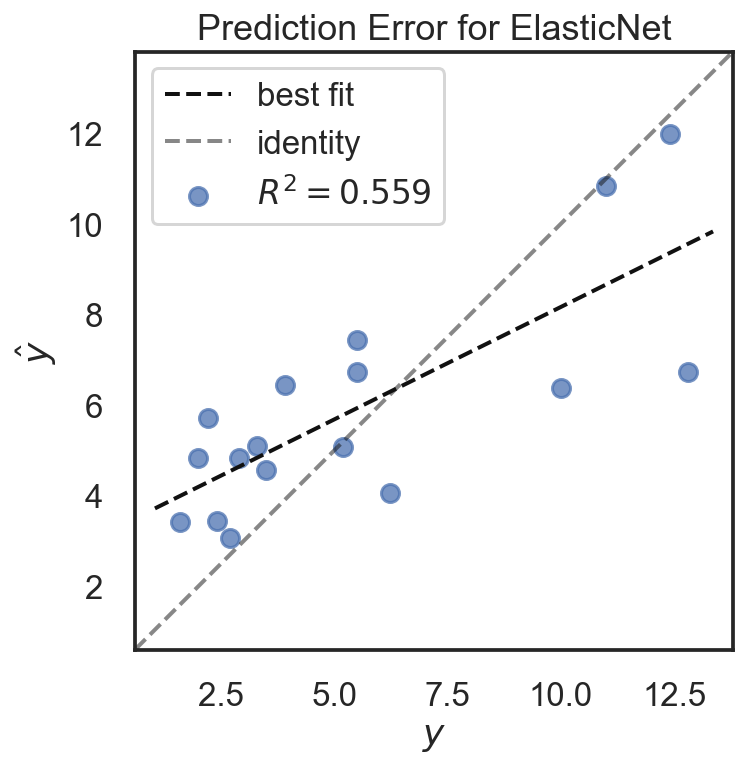

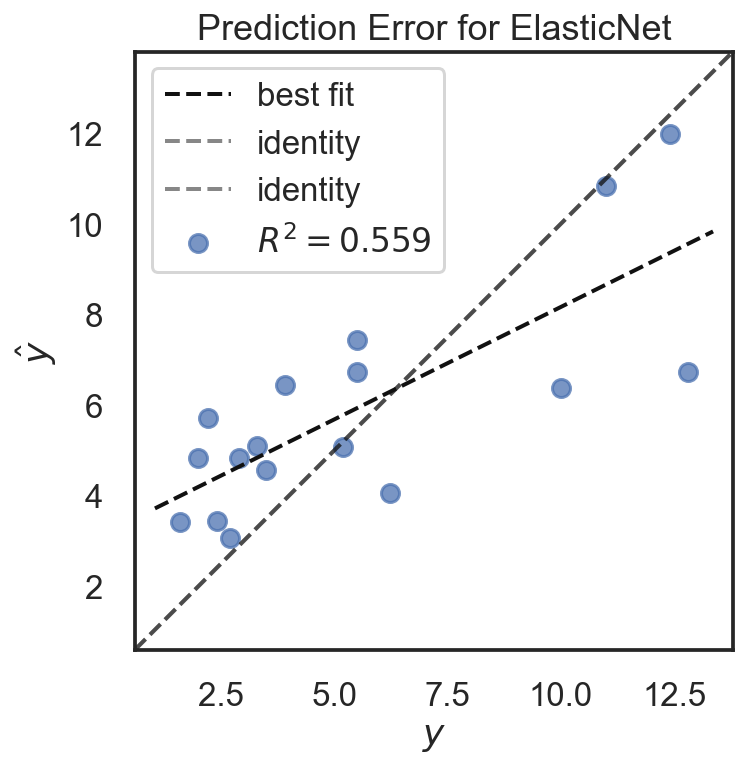

In [66]:
error_plot(df_features[TWfeatures.columns].values, 
           RCCdataframe['Tumor Width'], el);
#error_plot_save(df_features[TWfeatures.columns].values, 
#           RCCdataframe['Tumor Width'], el, 'ElasticNetRegressor_PredictionPlot.svg');

*SupportVectorRegressor*

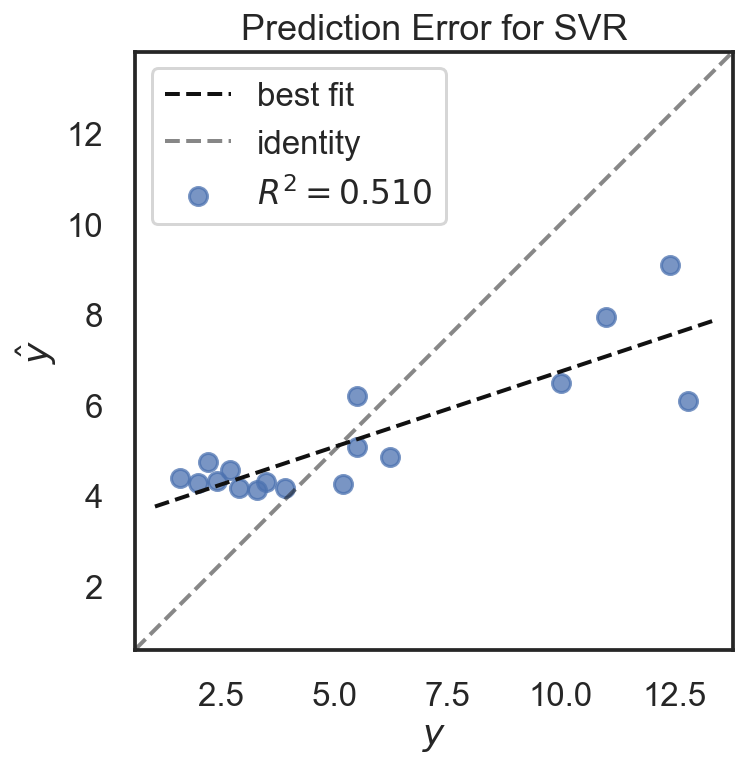

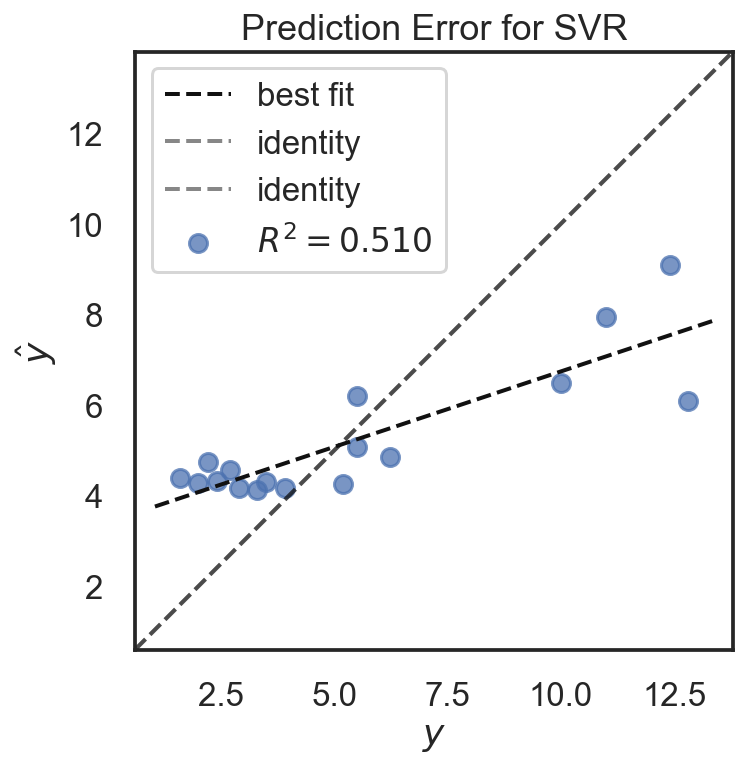

In [62]:
error_plot(df_features[TWfeatures.columns].values, 
           RCCdataframe['Tumor Width'], svr);
#error_plot_save(df_features[TWfeatures.columns].values, 
#           RCCdataframe['Tumor Width'], svr, 'SVRRegressor_PredictionPlot.svg');

*RidgeRegressor*

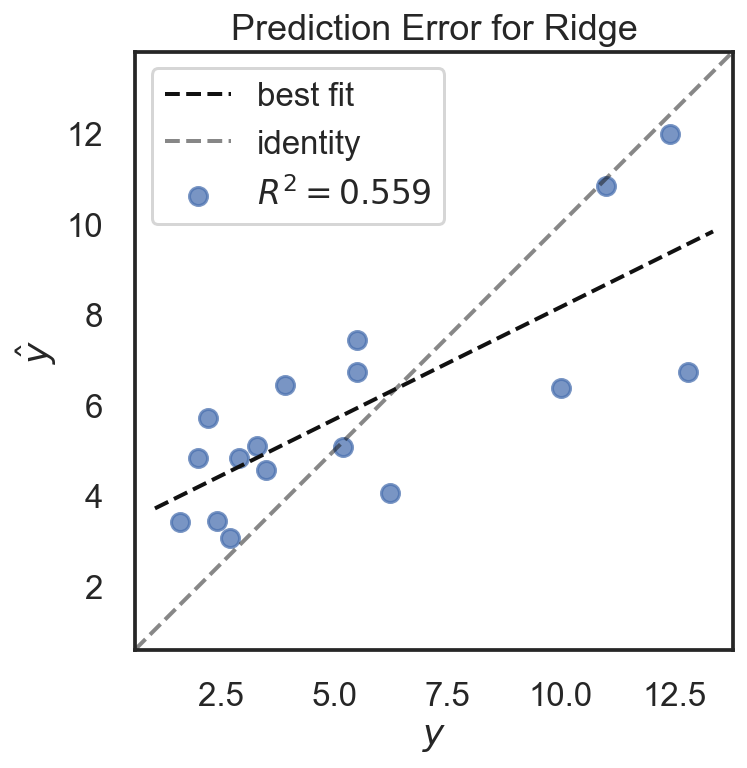

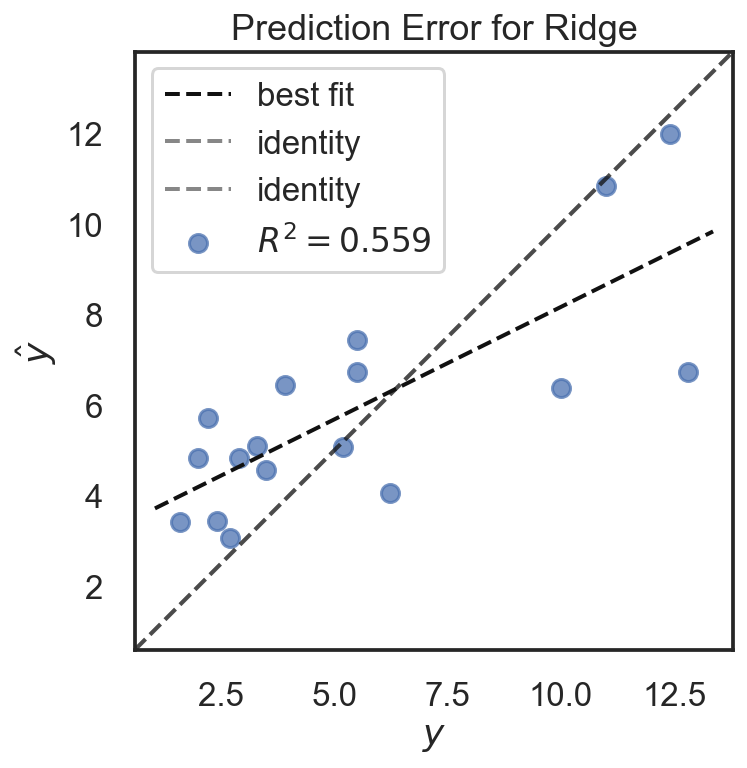

In [63]:
error_plot(df_features[TWfeatures.columns].values, 
           RCCdataframe['Tumor Width'], ridge);
#error_plot_save(df_features[TWfeatures.columns].values, 
#           RCCdataframe['Tumor Width'], ridge, 'Ridge_PredictionPlot.svg');

_Voting Regressor_

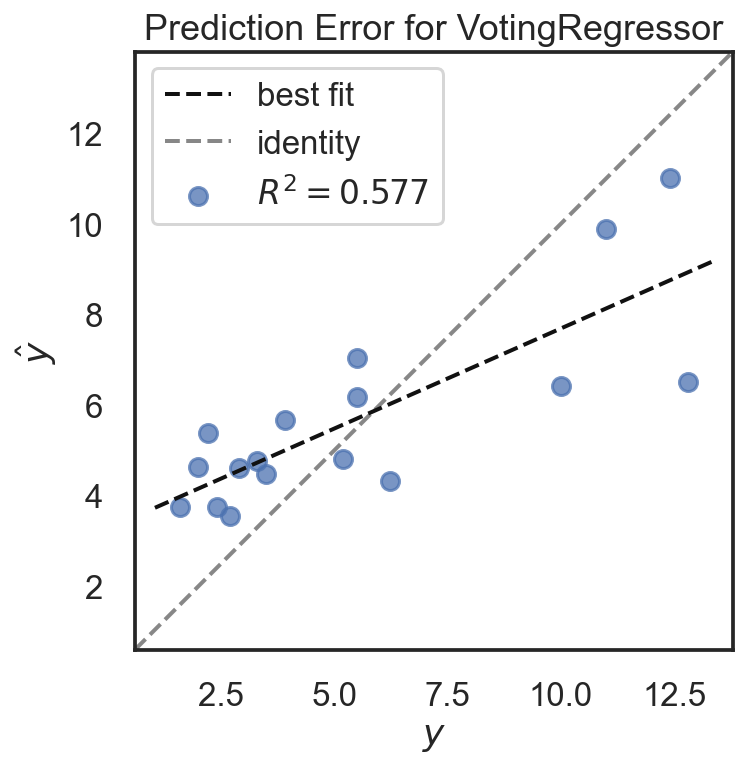

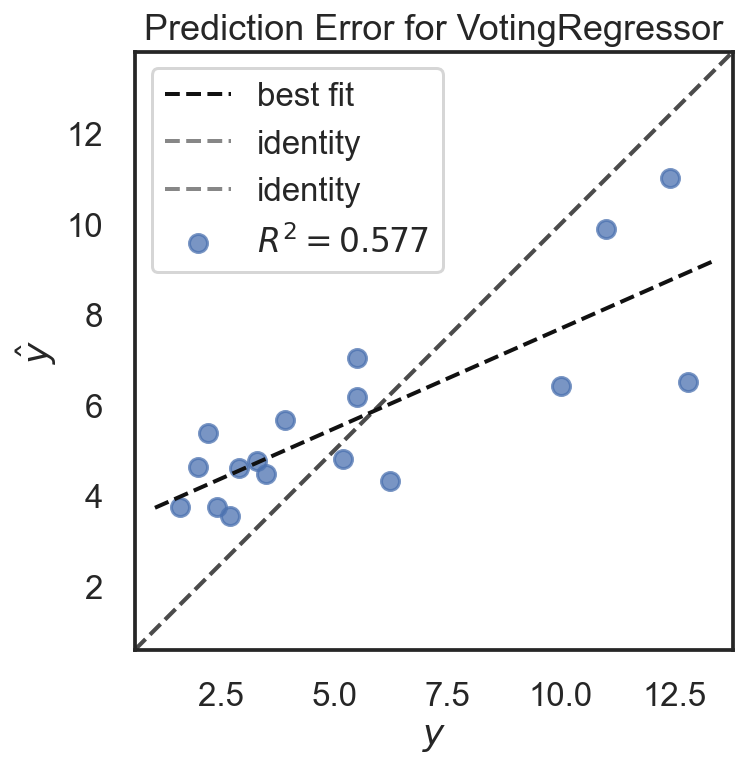

In [64]:
error_plot(df_features[TWfeatures.columns].values, 
           RCCdataframe['Tumor Width'], voting_reg);
#error_plot_save(df_features[TWfeatures.columns].values, 
#           RCCdataframe['Tumor Width'], voting_reg, 'VotingRegressor_PredictionPlot.svg');

In [65]:
#import dill                            
#filepath = 'tumor_size_prediction_model.pkl'
#dill.dump_session(filepath) # Save the session